In [1]:
import os
import sys
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

### Subjects

In [5]:
## All subjects ##
group_title = 'all'
PCImeancolor = 'darkblue'

sub_dirs = {
    '551399': r'F:\EEG_exp\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
    '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
    '569073a': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '571619a': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
    '569070': r'F:\EEG_exp\mouse569070\estim1_2021-04-01_10-27-33\experiment1\recording1',
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\experiment1\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estim1_2020-07-30_11-25-05\experiment1\recordingfull',
    '543393': r'F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
#     '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1', # too few resting trials
    '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1', # too many bad chs
    '575102': r'F:\EEG_exp\mouse575102\estim_vis_2021-06-03_11-25-01\experiment1\recording1',
#     '575100': r'F:\EEG_exp\mouse575100\estim_vis_2021-06-10_11-39-06\experiment1\recording1', # 100um offset stim electrode
    '571619b': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
    '569073b': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '571620a': r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1',
    '571620b': r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1',
    '586466a': r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1',
    '586466b': r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1',
    '586468': r'F:\EEG_exp\mouse586468\estim_vis_2021-08-19_11-36-53\experiment1\recording1',
}

brain_states = {
    '551399': {'awake': [0], 'anesthetized': [1]},
    '551397': {'awake': [0], 'anesthetized': [1]},
    '569062': {'awake': [0], 'anesthetized': [1]},
    '569068': {'awake': [0], 'anesthetized': [1]},
    '569069': {'awake': [0], 'anesthetized': [1]},
    '569064': {'awake': [0], 'anesthetized': [1]},
    '569073a': {'awake': [0], 'anesthetized': [1]},
    '571619a': {'awake': [1], 'anesthetized': [2]},
    '569070': {'awake': [0], 'anesthetized': [1]},
    '521885': {'awake': [0], 'anesthetized': [1]},
    '521886': {'awake': [0], 'anesthetized': [1]},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4]},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5]},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5]},
#     '543396': {'awake': [0], 'anesthetized': [1]},
    '546655': {'awake': [0], 'anesthetized': [1]},
#     '571618': {'awake': [0], 'anesthetized': [1]},
    '575102': {'awake': [0], 'anesthetized': [1]},
#     '575100': {'awake': [0], 'anesthetized': [1]},
    '571619b': {'awake': [0], 'anesthetized': [3]},
    '569073b': {'awake': [0], 'anesthetized': [1]},
    '569072': {'awake': [0], 'anesthetized': [1]},
    '571620a': {'awake': [0], 'anesthetized': [3]},
    '571620b': {'awake': [1], 'anesthetized': [2]},
    '586466a': {'awake': [0], 'anesthetized': [3]},
    '586466b': {'awake': [1], 'anesthetized': [2]},
    '586468': {'awake': [1], 'anesthetized': [2]},
}

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load experiments

In [7]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment 

In [8]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load eeg data and gather stim-evoked traces

In [9]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 2. # s, look at 1 s post-stim

apply_mask = True
apply_hpass = True
apply_car = True

In [10]:
amp_tags = {0: 'low', 1: 'medium', 2: 'high'}
print(len(amp_tags))
for tag in amp_tags.values():
    print(type(tag))

3
<class 'str'>
<class 'str'>
<class 'str'>


In [11]:
# start = time.time()

EEG_traces = {}
sub_good_chs = {}
PCI_stim_amp = {}
for mousei, expi in sub_exp.items():
    print(mousei[:6])
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = zzmetadata[(
        (zzmetadata['mouse_name'].str.contains(expi.mouse[:6])) &
        (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(expi.experiment_folder))))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['EEG bad_channels'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
    
    ## Get PCI_stim_amp from metadata ##
    currentstr = expi_meta['Current (uA)'].replace(' ','')
    currents_list = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            currents_list.append(int(char))
    if len(currents_list) > 1:
        PCI_stim_amp[mousei] = currents_list[1]
    elif len(currents_list) == 1:
        PCI_stim_amp[mousei] = currents_list[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    
    ## Load stim log ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
#     amps_list = np.sort(stim_log.loc[stim_log.stim_type == 'biphasic', 'parameter'].unique())
    
    # load data ##
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
    
    ## Load running signal ##
    run_signal, run_timestamps = expi.load_running()
    
    ## Mask estim artifact ##
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    start = time.time()
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    end = time.time()
    print('  time to highpass filter: {:.2f} s'.format((end - start)))
    
    ## Get evoked traces ##
    EEG_traces[mousei] = {}
    for statei, sweeps in brain_states[mousei].items():
        if sweeps:
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', str(PCI_stim_amp[mousei]), sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            ## Get evoked EEG traces ##
            event_traces, event_ts = get_evoked_traces(
                datai, tsi, state_events[rest_events], before_event, after_event, expi.ephys_params['EEG']['sample_rate']
            )
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
            ## Apply lowpass filter ##
            filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
            EEG_traces[mousei][statei] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
    sub_good_chs[mousei] = good_chs
            
    del datai
    del tsi
    del stim_log
    del run_signal
    del run_timestamps

# end = time.time()
# print('Time to analyze: {:.2f} min'.format((end - start) / 60))

551399
  time to highpass filter: 26.41 s
 awake state: resting trials 108/120
 anesthetized state: resting trials 120/120
551397
  time to highpass filter: 33.92 s
 awake state: resting trials 96/120
 anesthetized state: resting trials 120/120
569062
  time to highpass filter: 30.39 s
 awake state: resting trials 102/120
 anesthetized state: resting trials 119/120
569068
  time to highpass filter: 34.04 s
 awake state: resting trials 99/120
 anesthetized state: resting trials 119/119
569069
  time to highpass filter: 34.14 s
 awake state: resting trials 82/119
 anesthetized state: resting trials 120/120
569064
  time to highpass filter: 37.34 s
 awake state: resting trials 116/120
 anesthetized state: resting trials 118/118
569073
  time to highpass filter: 39.63 s
 awake state: resting trials 86/111
 anesthetized state: resting trials 120/120
571619
  time to highpass filter: 29.14 s
 awake state: resting trials 97/118
 anesthetized state: resting trials 120/120
569070
  time to high

# Calculate PCIst in sliding window, match trial numbers of states; only for PCI stim amp

In [12]:
window_size = 0.1 # window size, s
slide_time = 0.02 # overlap of sliding windows
window_starts = np.arange(0, slide_time + 1.0, slide_time)
print(len(window_starts))

51


In [13]:
PCI_params = {
    'baseline_window': (-0.8, -0.001), # s before stim for baseline, my default: (-0.5, -0.001)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

In [14]:
sliding_PCI = {}
for subject in EEG_traces.keys():
    print(subject)
    
    NUM_TRIALS = min([EEG_traces[subject][x][1].shape[2] for x in EEG_traces[subject].keys()])
    print(' Good channels: {:d}'.format(sub_good_chs[subject].shape[0]))
    print(' Trials: {:d}'.format(NUM_TRIALS))
    
    if NUM_TRIALS < 30:
        print('Not enough trials, not computing PCI.')
        print('')
        continue
    
    sliding_PCI[subject] = {}
    for statei in EEG_traces[subject].keys():
        start = time.time()
        state_traces = np.mean(EEG_traces[subject][statei][1][:, :, :NUM_TRIALS], axis=2)
        
        time_PCI = np.zeros_like(window_starts)
        for j, windowj in enumerate(window_starts):
            PCI_params['response_window'] = (windowj, windowj + window_size)
        
            ## Calculate PCIst with full return ##
            time_PCI[j] = calc_PCIst(
                state_traces[:, sub_good_chs[subject]].T,
                EEG_traces[subject][statei][0],
                full_return=False,
                **PCI_params
            );
        
        sliding_PCI[subject][statei] = time_PCI
        
        end = time.time()
        print(' {} time: {:.2f} s'.format(statei, (end-start)))
    print('')

551399
 Good channels: 22
 Trials: 108
 awake time: 514.99 s
 anesthetized time: 482.52 s

551397
 Good channels: 27
 Trials: 96
 awake time: 716.51 s
 anesthetized time: 382.88 s

569062
 Good channels: 28
 Trials: 102
 awake time: 672.07 s
 anesthetized time: 246.86 s

569068
 Good channels: 30
 Trials: 99
 awake time: 557.71 s
 anesthetized time: 193.23 s

569069
 Good channels: 30
 Trials: 82
 awake time: 812.68 s
 anesthetized time: 165.89 s

569064
 Good channels: 30
 Trials: 116
 awake time: 777.49 s
 anesthetized time: 229.95 s

569073a
 Good channels: 27
 Trials: 86
 awake time: 697.72 s
 anesthetized time: 212.25 s

571619a
 Good channels: 25
 Trials: 97
 awake time: 704.03 s
 anesthetized time: 398.19 s

569070
 Good channels: 26
 Trials: 86
 awake time: 586.65 s
 anesthetized time: 285.75 s

521885
 Good channels: 17
 Trials: 47
 awake time: 742.22 s
 anesthetized time: 536.96 s

521886
 Good channels: 20
 Trials: 87
 awake time: 467.56 s
 anesthetized time: 341.78 s

52188

### Plot population PCI time course

In [15]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

In [16]:
sstates = list(brain_states[list(brain_states.keys())[0]].keys())
PCI_time = {}
for statei in sstates:
    state_matrix = np.zeros((len(window_starts), len(sliding_PCI.keys())), dtype=float)
    for ii, mousei in enumerate(sliding_PCI.keys()):
        state_matrix[:,ii] = sliding_PCI[mousei][statei]
    PCI_time[statei] = state_matrix

Need to add some stats to this plot

<IPython.core.display.Javascript object>


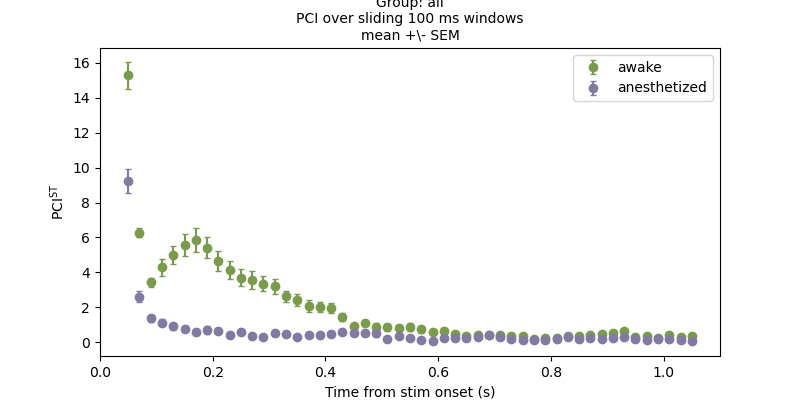

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
timex = window_starts + (window_size / 2)
for statei in PCI_time.keys():
    mean_PCI = np.mean(PCI_time[statei], axis=1)
    sem_PCI = np.std(PCI_time[statei], axis=1) / np.sqrt(PCI_time[statei].shape[1])
    ax.errorbar(timex, mean_PCI, yerr=sem_PCI, color=state_colors[statei], linestyle='none', marker='o', label=statei)
    
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('Group: {}\nPCI over sliding {:d} ms windows\nmean +\- SEM'.format(group_title, int(window_size*1e3)))
ax.legend()

## Save ##
figname = 'slidingPCI_multisub_{}.png'.format(group_title)
# fig.savefig(os.path.join(plotsdir, figname))

Plot PCI time course for one subject

<IPython.core.display.Javascript object>


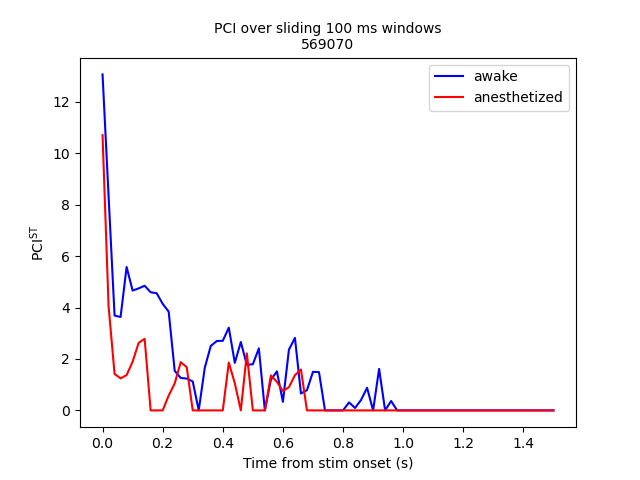

In [16]:
mouse = '569070'
fig, ax = plt.subplots()
ax.plot(window_starts, sliding_PCI[mouse]['awake'], 'b', label='awake')
ax.plot(window_starts, sliding_PCI[mouse]['anesthetized'], 'r', label='anesthetized')
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('PCI over sliding {:d} ms windows\n{}'.format(int(window_size*1e3), mouse))
ax.legend()

## Save ##
figname = 'slidingPCI_singlesub_{}.png'.format(mouse)
# fig.savefig(os.path.join(plotsdir, figname))

#### Plot PCI values

In [18]:
justPCI = {}
for mousei in full_PCI_output.keys():
    justPCI[mousei] = {}
#     for statei in states:
    for statei in full_PCI_output[mousei].keys():
        justPCI[mousei][statei] = full_PCI_output[mousei][statei]['PCI']

In [19]:
pci_eqn = pd.DataFrame(justPCI, index=states)
PCIvalues_eqn = pci_eqn.to_numpy()
pci_eqn.head()

,551399,551397,569062,569068,569069,569064,569073a,521886,521887,543393,543394
awake,41.107435,81.323484,59.935993,22.356748,60.481266,61.394153,49.066713,38.362708,51.025471,53.578071,32.975197
anesthetized,22.186226,18.968796,15.525097,2.083125,8.459243,2.096645,2.600669,9.776489,9.022899,6.161292,14.235214
recovery1,37.425336,49.201908,46.950225,19.430960,45.966978,49.934213,24.541657,16.442455,49.915791,4.403979,28.464586
recovery2,43.957729,38.022250,NaN,15.070485,33.142191,51.294559,23.068036,NaN,NaN,NaN,NaN


#### Paired t-test
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [22]:
## Calculate the t-test on TWO RELATED samples of scores, a and b.
t2, p2 = stats.ttest_rel(PCIvalues_eqn[0,:], PCIvalues_eqn[1,:])
print("t = " + str(t2))
print("p = " + str(p2))
### is this a paired ttest???

t = 8.31280639460075
p = 8.401928412593603e-06


### Plot individuals and mean

<IPython.core.display.Javascript object>


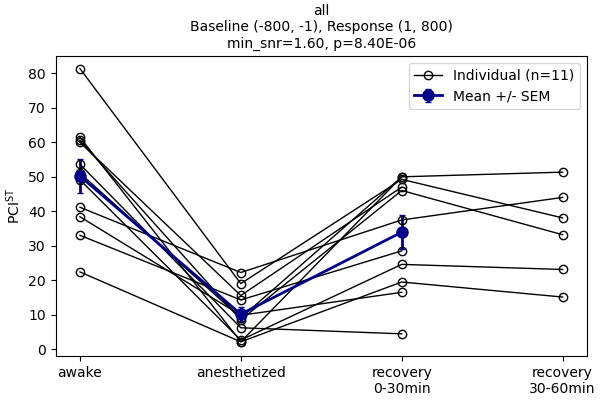

In [26]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, PCIvalues_eqn.shape[0]),
    np.mean(PCIvalues_eqn, axis=1),
    yerr=stats.sem(PCIvalues_eqn, axis=1),
    color=PCImeancolor, 
    linewidth=2,
    marker='o',
    markersize=8,
)
# annotate with asterisk
# if p2 < 0.01:
#     ax.annotate('*', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12, fontweight='bold')

# ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-2, 85])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
# ax.set_xticklabels(states, fontsize=10)
ax.set_xticklabels(['awake', 'anesthetized', 'recovery\n0-30min', 'recovery\n30-60min'], fontsize=10)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=10)
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1])), 'Mean +/- SEM'])
# ax.legend([individs[0]], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1]))])
ax.set_title(
    '{}\nBaseline ({:d}, {:d}), Response ({:d}, {:d})\nmin_snr={:.2f}, p={:.2E}'.format(
        group_title,
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        PCI_params['min_snr'],
        p2
    ))

## Save ##
figname = 'PCI_{}_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}_allstates.png'.format(
    group_title,
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)